In [1]:
import numpy as np
import pandas as pd

import random
random.seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv(
    r"C:\Users\HP\Text-Based-Risk-Classification-System\Text-Based-Risk-Classification-System\data\spam.csv",
    encoding="latin-1"
)


df = df[['v1', 'v2']]
df.columns = ['label', 'text']

df['label'] = df['label'].map({'ham': 0, 'spam': 1})

df = df.drop_duplicates().reset_index(drop=True)


In [4]:
# basic length features
df['message_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# numeric-related features
df['number_count'] = df['text'].str.count(r'\d+')
df['contains_number'] = (df['number_count'] > 0).astype(int)

# special characters
df['special_char_count'] = df['text'].str.count(r'[^\w\s]')

# url indicator
df['has_url'] = df['text'].str.contains(r'http|www', regex=True).astype(int)


In [5]:
df['text_model'] = df['text'].str.lower()


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df,
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)

X_train_text = tfidf.fit_transform(X_train['text_model'])
X_test_text  = tfidf.transform(X_test['text_model'])



In [12]:

from sklearn.preprocessing import StandardScaler

num_features = [
    'message_length',
    'word_count',
    'number_count',
    'contains_number',
    'special_char_count',
    'has_url'
]

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_features])
X_test_num  = scaler.transform(X_test[num_features])

In [13]:
from scipy.sparse import hstack

X_train_final = hstack([X_train_text, X_train_num])
X_test_final  = hstack([X_test_text, X_test_num])


In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    penalty='l2',              # standard, stable
    C=1.0,                     # regularization strength
    class_weight='balanced',   # handle imbalance
    solver='liblinear',        # good for sparse data
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

lr.fit(X_train_final, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()


In [17]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 2.0 MB/s eta 0:00:37
    --------------------------------------- 1.0/72.0 MB 2.1 MB/s eta 0:00:35
    --------------------------------------- 1.3/72.0 MB 1.8 MB/s eta 0:00:40
   - -------------------------------------- 1.8/72.0 MB 2.1 MB/s eta 0:00:34
   - -------------------------------------- 2.6/72.0 MB 2.3 MB/s eta 0:00:30
   - -------------------------------------- 3.1/72.0 MB 2.4 MB/s eta 0:00:30
   -- ------------------------------------- 3.7/72.0 MB 2.4 MB/s eta 0:00:29
   -- ------------------------------------- 4.7/72.0 MB 2.7 MB/s eta 0:00:25
   --- ------------------------------------ 6.0/72.0 MB 3.1 MB/s eta 0:00:22
   --- ------------------------------------ 7.1/72.0 MB 3.3 MB/s eta 0:00:20
   ---- ----


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',

    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,

    subsample=0.8,
    colsample_bytree=0.8,

    min_child_weight=1,
    gamma=0,

    scale_pos_weight=scale_pos_weight,

    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train_final, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [19]:
from sklearn.metrics import classification_report

print("Logistic Regression")
print(classification_report(y_test, lr.predict(X_test_final)))

print("XGBoost")
print(classification_report(y_test, xgb.predict(X_test_final)))


Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       903
           1       0.88      0.94      0.91       131

    accuracy                           0.98      1034
   macro avg       0.94      0.96      0.95      1034
weighted avg       0.98      0.98      0.98      1034

XGBoost
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.91      0.92      0.92       131

    accuracy                           0.98      1034
   macro avg       0.95      0.96      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [20]:
y_probs_xgb = xgb.predict_proba(X_test_final)[:, 1]


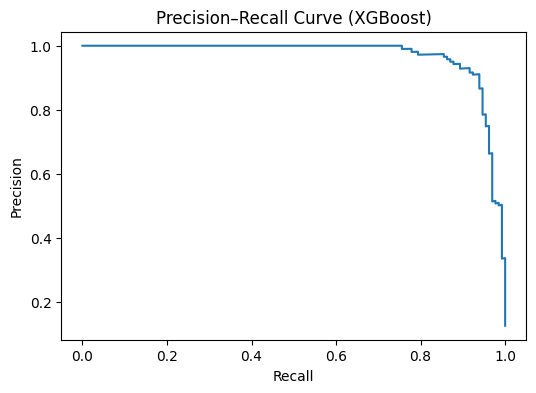

In [21]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_xgb)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost)")
plt.show()


In [22]:
custom_threshold = 0.42

y_pred_custom = (y_probs_xgb >= custom_threshold).astype(int)


In [23]:
from sklearn.metrics import classification_report

print("XGBoost with threshold =", custom_threshold)
print(classification_report(y_test, y_pred_custom))


XGBoost with threshold = 0.42
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.91      0.94      0.92       131

    accuracy                           0.98      1034
   macro avg       0.95      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [24]:
import pandas as pd

results = []

for t in [0.3, 0.4, 0.42, 0.5, 0.6]:
    y_pred_t = (y_probs_xgb >= t).astype(int)

    report = classification_report(y_test, y_pred_t, output_dict=True)
    
    results.append({
        "threshold": t,
        "precision_spam": report["1"]["precision"],
        "recall_spam": report["1"]["recall"],
        "f1_spam": report["1"]["f1-score"]
    })

pd.DataFrame(results)


,threshold,precision_spam,recall_spam,f1_spam
0,0.30,0.884892,0.938931,0.911111
1,0.40,0.904412,0.938931,0.921348
2,0.42,0.911111,0.938931,0.924812
3,0.50,0.909774,0.923664,0.916667
4,0.60,0.929688,0.908397,0.918919


In [27]:
final_threshold = 0.42